In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/rgf3807/PycharmProjects/CC-RNNs")
from src import RNN, ConceptorRNN
from src.functions import init_weights, AND, NOT

%matplotlib inline
device = "cpu"
dtype = torch.float64

# Computing with RNNs

We consider recurrent neural network models of the standard form

$$y(n+1) = \tanh[W y(n) + W_{in} x(n) + b]$$.
$$z(n+1) = W_{out} y(n+1)$$

This network has a state vector $y \in \mathbb{R}^N$ and the recurrent weights $W \in \mathbb{R}^{N \times N}$, input weights $W_{in} \in \mathbb{R}^{N \times m}$ and a bias vector $b \in \mathbb{R}^N$ as model parameters.
The vector $z \in \mathbb{R}^k$ represents a linear readout (or observed signal) from the network, obtained via the readout projection $W_{out} \in \mathbb{R}^{k \times N}$, whereas $x(n) \in \mathbb{R}^{m}$ is the input pattern at time step $n$. 

<img src="rc.png" width="800">

We will discuss the following questions:

- How can we extract (and process) information from the inputs $x(n)$ via such a network architecture?
- What are common issues to be aware of when training such networks?
- What options exist for controlling the network, i.e. forcing it to express a desirable activation pattern?

As an examplary problem, we will attempt to reconstruct the Lorenz attractor with such an RNN.
The Lorenz attractor is defined as follows

$$ \dot x_1 = s(x_2 - x_1),$$
$$ \dot x_2 = rx_1 - x_2 - x_2 x_3,$$
$$ \dot x_3 = x_1 x_2 - b x_3.$$

Choosing $s = 10$, $r = 28$, and $b = \frac{8}{3}$ yields the well-known chaotic Lorenz attractor.
The equations have been introduced by Edward Lorenz in 1963 as a simplified model of atmospheric convection and is one of the most famous examples of a dynamical system capable of generating chaos.

**Recommendations for working through the notebook yourself:**

- Play around with parameters $s$, $r$, and $b$ of the Lorenz equations and check how it affects the obtained solutions
- The differential equations are solved via a simple forward Euler integration method. You can change the integration step size `dt` and check its effect on the quality of the obtained solutions

In [14]:
def lorenz(x1: float, x2: float, x3: float, s: float = 10.0, r: float = 28.0, b: float = 2.667) -> np.ndarray:
    """
    Parameters
    ----------
    x1, x2, x3: float
        State variables.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    np.ndarray
       Vectorfield of the Lorenz equations.
    """
    x1_dot = s*(x2 - x1)
    x2_dot = r*x1 - x2 - x1*x3
    x3_dot = x1*x2 - b*x3
    return np.asarray([x1_dot, x2_dot, x3_dot])

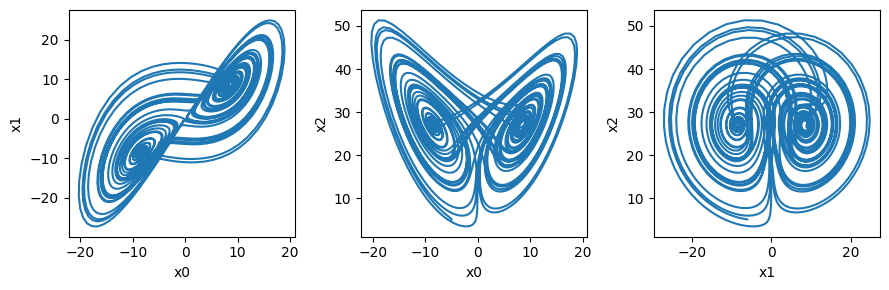

In [15]:
# lorenz equation parameters
s = 10.0
r = 28.0
b = 8/3
dt = 0.01
steps = 100000
init_steps = 1000
lag = 4

# simulation
x = np.asarray([-5.0, -5.0, 5.0])
n_in = len(x)
x_col = []
for step in range(steps):
    x = x + dt * lorenz(x[0], x[1], x[2], s=s, r=r, b=b)
    x_col.append(x)
x_col = torch.tensor(np.asarray(x_col), device=device, dtype=dtype)

# get inputs and targets
inputs = x_col[:-lag]
targets = x_col[lag:]

# plot input
plot_steps = 4500
fig, axes = plt.subplots(ncols=n_in, figsize=(9, 3))
combinations = [[0, 1], [0, 2], [1, 2]]
for i in range(n_in):
    ax = axes[i]
    idx = combinations[i]
    ax.plot(inputs[:plot_steps, idx[0]], inputs[:plot_steps, idx[1]])
    ax.set_xlabel(f"x{idx[0]}")
    ax.set_ylabel(f"x{idx[1]}")
plt.tight_layout()

## Training an RNN to solve a task

### (A) Network initialization

We will drive our RNN with the Lorenz attractor. The task of the network is to predict what its input will be $\tau$ time steps into the future. 

When setting up an RNN to solve some kind of task, I recommend to follow some basic steps to ensure a proper network initialization:

- if you randomly initialize your network parameters, control their scaling
- inspect your weight matrices
- inspect the RNN dynamics on constant input and in response to an impulse of representative strength
- change a few of your meta parameters and examine how they alter the network dynamics

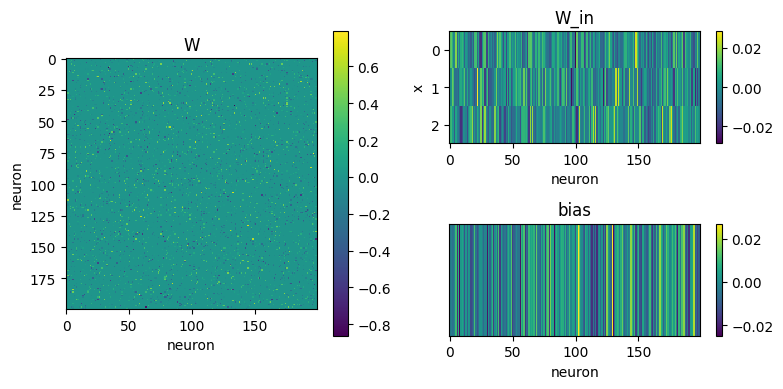

In [16]:
# rnn parameters
N = 200
sr = 1.05
bias_scale = 0.01
inp_scale = 0.01
density = 0.1

# initialize network parameters
W_in = inp_scale * np.random.randn(N, n_in)
bias = bias_scale * np.random.randn(N)
W = init_weights(N, N, density)
W *= sr/np.max(np.abs(np.linalg.eigvals(W)))

# plotting
fig = plt.figure(figsize=(8, 4))
grid = fig.add_gridspec(nrows=2, ncols=2)

ax = fig.add_subplot(grid[:, 0])
im = ax.imshow(W, aspect="equal", interpolation="none", cmap="viridis")
ax.set_xlabel("neuron")
ax.set_ylabel("neuron")
ax.set_title("W")
plt.colorbar(im, ax=ax)

ax = fig.add_subplot(grid[0, 1])
im = ax.imshow(W_in.T, aspect="auto", interpolation="none", cmap="viridis")
ax.set_xlabel("neuron")
ax.set_ylabel("x")
ax.set_title("W_in")
plt.colorbar(im, ax=ax)

ax = fig.add_subplot(grid[1, 1])
im = ax.imshow(np.reshape(bias, (N, 1)).T, aspect="auto", interpolation="none", cmap="viridis")
ax.set_xlabel("neuron")
ax.set_title("bias")
ax.set_yticks([])
plt.colorbar(im, ax=ax)
plt.tight_layout()

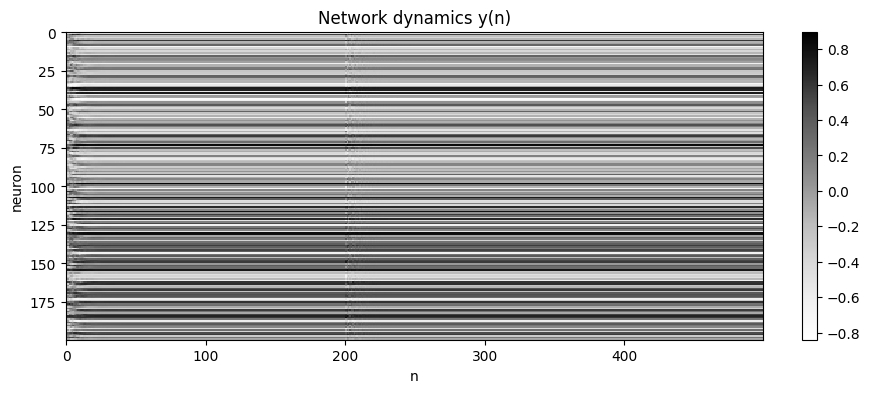

In [17]:
# initialize RNN
rnn = RNN(W=torch.tensor(W, device=device, dtype=dtype), 
          W_in=torch.tensor(W_in, device=device, dtype=dtype), 
          bias=torch.tensor(bias, device=device, dtype=dtype))

# initial wash-out period
init_steps = 500
avg_input = torch.mean(inputs, dim=0)
y_col = []
with torch.no_grad():
    for step in range(init_steps):
        if step == 200:
            y = rnn.forward(avg_input + 10.0)
        else:
            y = rnn.forward(avg_input)
        y_col.append(y.detach().cpu().numpy())

# plotting of the network dynamics
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(np.asarray(y_col).T, aspect="auto", interpolation="none", cmap="Greys")
plt.colorbar(im, fraction=0.05)
ax.set_xlabel("n")
ax.set_title("Network dynamics y(n)")
_ = ax.set_ylabel("neuron")

### (B) Readout training

Now that we have initialized a healthy RNN, let's optimize the model to perform the prediction task.
Here is how classic reservoir computing solves the model optimization problem:

- We would like to find a set of readout weights $W_{out}$ such that $W_{out} = \mathrm{argmin}_{\bar W} \sum_{n} || z^*(n) - \bar W y(n)||^2 + \alpha^2 ||\bar W||^2$

- Analytic solution to this minimization problem: $W_{out} = ((Y Y' + \alpha^2 I)^{\dagger} Y Z')'$

- 2-step approach: (1) collect network states for $T$ input-driven steps, (2) calculate $W_{out}$ via the above equation

**Recommendations for working through the notebook yourself:**

Go through the cells of (A) and (B) multiple times and test the following.

- how do changes in the spectral radius `sr` and the scaling of the input and bias affect the quality of your readout training?
- how does the range of values in your network parameters `W`, `W_in`, and `bias` affect the network dynamics for constant input?
- Can you predict something about the training performance from the impulse response of the network dynamics?

Readout training error: 0.0004101583756475807


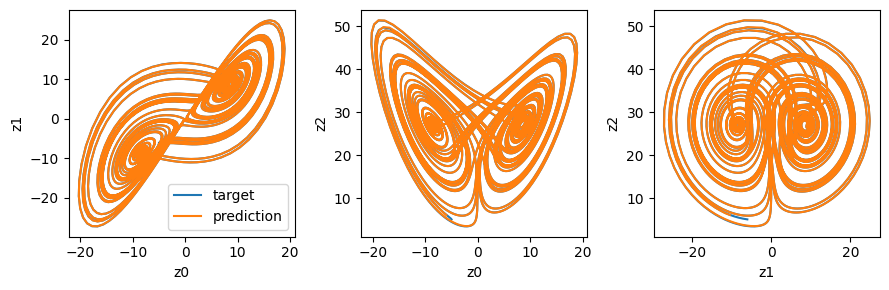

In [18]:
# training parameters
tychinov = 1e-3

# simulation of network dynamics
y_col = []
for step in range(steps-lag):
    rnn.forward(inputs[step])
    y_col.append(rnn.y)
y_col = torch.stack(y_col, dim=0)

# train readout
W_out, epsilon = rnn.train_readout(y_col.T, targets.T, tychinov)
predictions = y_col @ W_out.T
print(f"Readout training error: {float(torch.mean(epsilon).cpu().detach().numpy())}")

# plotting
fig, axes = plt.subplots(ncols=n_in, figsize=(9, 3))
for i in range(n_in):
    ax = axes[i]
    idx = combinations[i]
    ax.plot(inputs[:plot_steps, idx[0]], inputs[:plot_steps, idx[1]], label="target")
    ax.plot(predictions[:plot_steps, idx[0]], predictions[:plot_steps, idx[1]], label="prediction")
    ax.set_xlabel(f"z{idx[0]}")
    ax.set_ylabel(f"z{idx[1]}")
    if i == 0:
        ax.legend()
plt.tight_layout()

**Essence of computing with RNNs:**

- dimensionality expansion of input signal
- input memory through network dynamics
- nonlinearity allows for complex transformations of input signal in high-dimensional network state space
- task-relevant dynamics are low-dimensional

If network is set up such that these central properties exist, then computing with RNNs is nothing else but identifying the task-relevant low-dimensional sub-spaces of your RNN. That sounds like a feasible way for biological neural networks to implement computations.

### (C) Input loading

We now have an RNN that can do a prediction, if it is driven with a particular input. Is meaningful activity in biological neural networks always input-driven, though? Predictive brain hypotheses would disagree. There are ways to transform a trained RNN into a generative model, however. 

In the case of the prediction task with $\tau = 1$, this is somewhat trivial and you could simply feed the readout $z(n)$ into the network as input at time step $n$, i.e. 

$$ y(n+1) = \tanh[W y(n) + z(n) + b].$$

However, this would fail for any other task that the network had to perform, even for $\tau = 2$.
As an alternative, we can harness the power of the low-dimensional sub-spaces and assume that there is a low-dimensional component of the RNN dynamics that merely reflects its input.
Then, we can identify that sub-space via 

$$ D = \mathrm{argmin}_{\bar D} \sum_{n} || x(n) - \bar D y(n)||^2 + \alpha^2 ||\bar D||^2. $$

Then, $W_{in} D y(n) \approx W_{in} x(n)$ and we can set up a network that generates a target output pattern autonomously:

$$ y(n+1) = \tanh[(W + W_{in} D) y(n)+ b] $$

Input loading error: 0.00010483535278029007


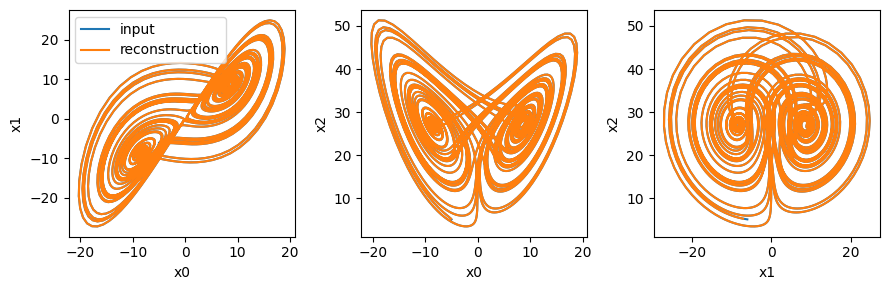

In [19]:
# load input into RNN weights
D, epsilon = rnn.load_input(y_col[:-1].T, inputs[1:].T, tychinov, overwrite=True)
print(f"Input loading error: {float(torch.mean(epsilon).cpu().detach().numpy())}")

# get input reconstruction
inp_recon = y_col @ D.T

# plot input reconstruction
fig, axes = plt.subplots(ncols=n_in, figsize=(9, 3))
for i in range(n_in):
    ax = axes[i]
    idx = combinations[i]
    ax.plot(inputs[:plot_steps, idx[0]], inputs[:plot_steps, idx[1]], label="input")
    ax.plot(inp_recon[:plot_steps, idx[0]], inp_recon[:plot_steps, idx[1]], label="reconstruction")
    ax.set_xlabel(f"x{idx[0]}")
    ax.set_ylabel(f"x{idx[1]}")
    if i == 0:
        ax.legend()
plt.tight_layout()

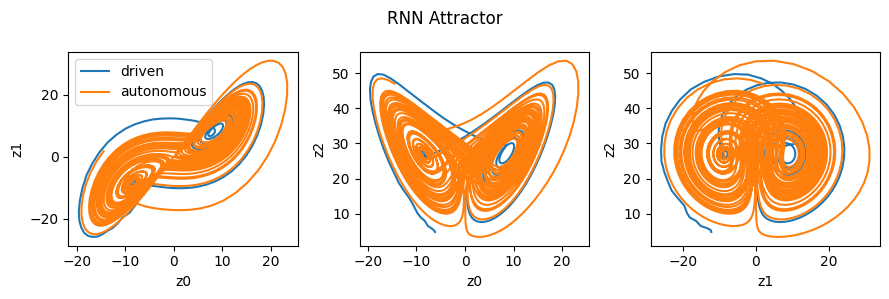

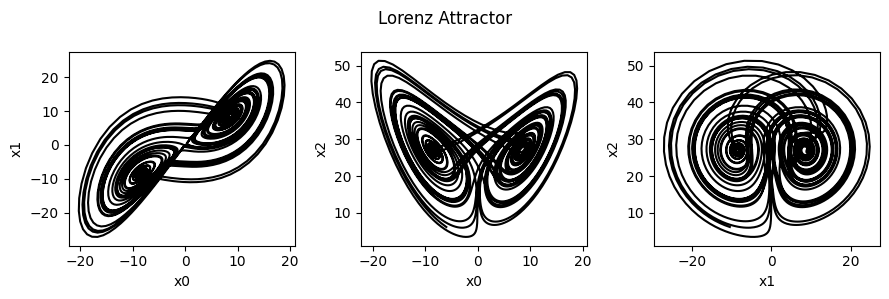

In [20]:
# simulation of autonomous network dynamics
predictions = []
transition = 500
for step in range(plot_steps):
    if step < transition:
        y = W_out @ rnn.forward(inputs[step])
    else:
        y = W_out @ rnn.forward_a()
    predictions.append(y.detach().cpu().numpy())
predictions = np.asarray(predictions)

# plotting prediction
fig, axes = plt.subplots(ncols=n_in, figsize=(9, 3))
for i in range(n_in):
    ax = axes[i]
    idx = combinations[i]
    ax.plot(predictions[:transition, idx[0]], predictions[:transition, idx[1]], label="driven")
    ax.plot(predictions[transition:plot_steps, idx[0]], predictions[transition:plot_steps, idx[1]], label="autonomous")
    ax.set_xlabel(f"z{idx[0]}")
    ax.set_ylabel(f"z{idx[1]}")
    if i == 0:
        ax.legend()
fig.suptitle("RNN Attractor")
plt.tight_layout()

# plotting target
fig2, axes2 = plt.subplots(ncols=n_in, figsize=(9, 3))
for i in range(n_in):
    ax = axes2[i]
    idx = combinations[i]
    ax.plot(targets[:plot_steps, idx[0]], targets[:plot_steps, idx[1]], color="black")
    ax.set_xlabel(f"x{idx[0]}")
    ax.set_ylabel(f"x{idx[1]}")
fig2.suptitle("Lorenz Attractor")
plt.tight_layout()

## Training an RNN to solve two tasks

An RNN trained as above is a very narrow computing machine. After training, it can do a single input-output mapping. 
Motivated by evidence from The Brain<em> &#8482; </em>, we are interested in the potential of RNNs to learn multiple input-output mappings, or richer/more flexible (generative) models of their inputs.

### (A) Standard approach

Let's first explore the restrictions of the tools that we applied above when attempting to train an RNN on a second task. The task - same as before, but for a different, less chaotic parameterization of the Lorenz equations.

**Comment for working through the notebook yourself:**

The next couple of cells will be the same as above, but for a different set of Lorenz equation parameters.

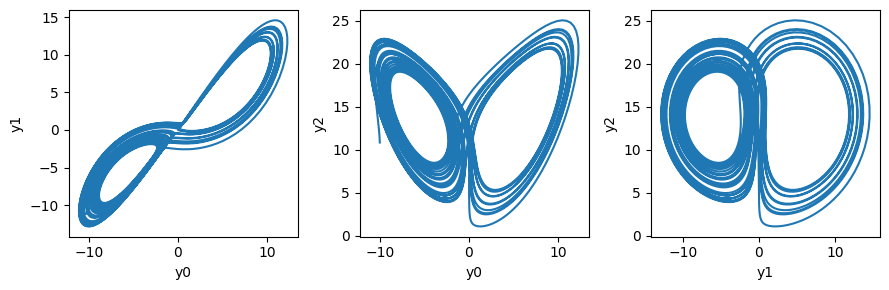

In [21]:
# lorenz equation parameters
s = 10.0
r = 15.0
b = 7/3

# simulation
x = np.asarray([-10.0, -10.0, 10.1])
n_in = len(x)
x_col = []
for step in range(steps):
    x = x + dt * lorenz(x[0], x[1], x[2], s=s, r=r, b=b)
    x_col.append(x)
x_col = torch.tensor(np.asarray(x_col), device=device, dtype=dtype)

# get inputs and targets
inputs_new = x_col[:-lag]
targets_new = x_col[lag:]

# plot input
fig, axes = plt.subplots(ncols=n_in, figsize=(9, 3))
for i in range(n_in):
    ax = axes[i]
    idx = combinations[i]
    ax.plot(inputs_new[:plot_steps, idx[0]], inputs_new[:plot_steps, idx[1]])
    ax.set_xlabel(f"y{idx[0]}")
    ax.set_ylabel(f"y{idx[1]}")
plt.tight_layout()

Readout training error: 0.00036620359104193594


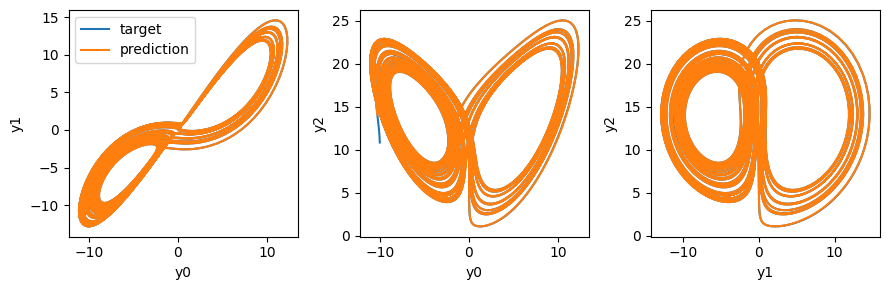

In [22]:
# simulation of network dynamics
y_col2 = []
for step in range(steps-lag):
    rnn.forward(inputs_new[step])
    y_col2.append(rnn.y)
y_col2 = torch.stack(y_col2, dim=0)

# train readout
W_out2, epsilon = rnn.train_readout(y_col2.T, targets_new.T, tychinov)
predictions_new = y_col2 @ W_out2.T
print(f"Readout training error: {float(torch.mean(epsilon).cpu().detach().numpy())}")

# plotting
fig, axes = plt.subplots(ncols=n_in, figsize=(9, 3))
for i in range(n_in):
    ax = axes[i]
    idx = combinations[i]
    ax.plot(inputs_new[:plot_steps, idx[0]], inputs_new[:plot_steps, idx[1]], label="target")
    ax.plot(predictions_new[:plot_steps, idx[0]], predictions_new[:plot_steps, idx[1]], label="prediction")
    ax.set_xlabel(f"y{idx[0]}")
    ax.set_ylabel(f"y{idx[1]}")
    if i == 0:
        ax.legend()
plt.tight_layout()

Input loading error: 9.949547733669568e-05


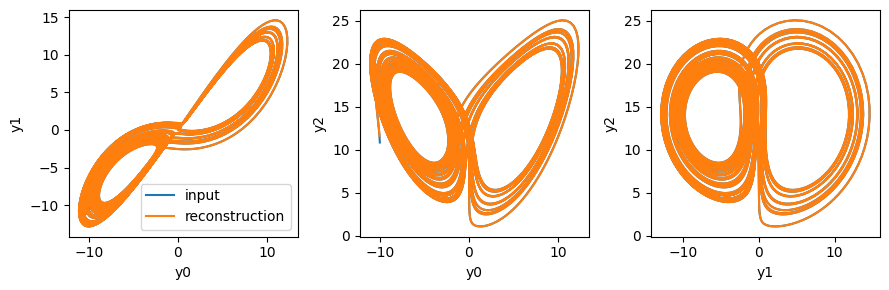

In [23]:
# load input into RNN weights
D2, epsilon = rnn.load_input(y_col2[:-1].T, inputs_new[1:].T, tychinov, overwrite=True)
print(f"Input loading error: {float(torch.mean(epsilon).cpu().detach().numpy())}")

# get input reconstruction
inp_recon = y_col2 @ D2.T

# plot input reconstruction
fig, axes = plt.subplots(ncols=n_in, figsize=(9, 3))
for i in range(n_in):
    ax = axes[i]
    idx = combinations[i]
    ax.plot(inputs_new[:plot_steps, idx[0]], inputs_new[:plot_steps, idx[1]], label="input")
    ax.plot(inp_recon[:plot_steps, idx[0]], inp_recon[:plot_steps, idx[1]], label="reconstruction")
    ax.set_xlabel(f"y{idx[0]}")
    ax.set_ylabel(f"y{idx[1]}")
    if i == 0:
        ax.legend()
plt.tight_layout()

Is there any interference between these tasks? What happens, for example, if we loaded both input signals into the RNN coupling?

**Comments for working through the notebook yourself:**

Below, I use the input reconstructions `D1` and `D2` to let the RNN generate Lorenz-like attractors autonomously. At some point, I use a linear combination of the two input reconstructions. I recommend to rerun the previous cells a couple of times to get different random initializations of the network and check what kind of different network dynamics you can get in this period where both `D1` and `D2` are applied.

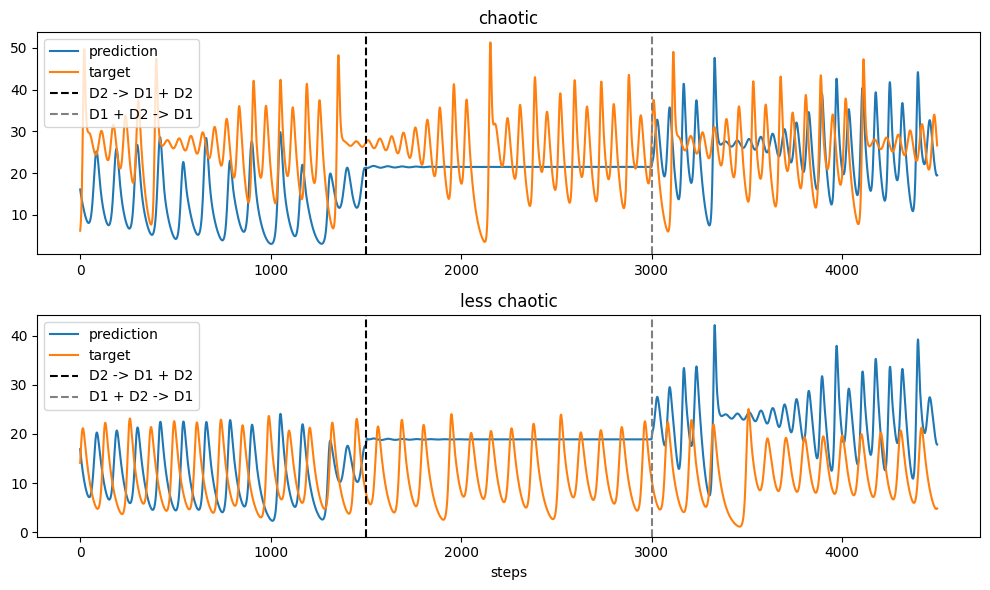

In [24]:
# simulation of autonomous network dynamics
predictions_old = []
predictions_new = []
rnn.D = rnn.W_in @ D2
y0 = rnn.y[:]
for step in range(plot_steps):
    if step == 1500:
        rnn.D = rnn.W_in @ (0.5*D + 0.5*D2)
    elif step == 3000:
        rnn.D = rnn.W_in @ D    
    y = rnn.forward_a()
    predictions_old.append((W_out @ y).detach().cpu().numpy())
    predictions_new.append((W_out2 @ y).detach().cpu().numpy())
predictions_old = np.asarray(predictions_old)
predictions_new = np.asarray(predictions_new)

# plotting
fig, axes = plt.subplots(nrows=2, figsize=(10, 6))
targs, preds = [targets, targets_new], [predictions_old, predictions_new]
labels = ["chaotic", "less chaotic"]
idx = 2
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(preds[i][:plot_steps, idx], label=f"prediction")
    ax.plot(targs[i][:plot_steps, idx], label=f"target")
    ax.axvline(x=1500, color="black", linestyle="dashed", label="D2 -> D1 + D2")
    ax.axvline(x=3000, color="grey", linestyle="dashed", label="D1 + D2 -> D1")
    ax.set_title(labels[i])
    ax.legend()
ax.set_xlabel("steps")
plt.tight_layout()

**How to train a single RNN on multiple tasks:**

- train a distinct set of readout weights for each task
- make sure that there is always just a single input pattern (i.e. task) active, or that all possible combinations of task co-activations are also part of the training procedure
- Alternative: Train all tasks of interest in a single step (instead of successively) and provide a context vector as additional input that tells the network which task to perform

<img src="rc.png" width="800">

**Problems with training RNNs on multiple tasks:**

- you cannot re-train any RNN weights for a new task without catastrophic forgetting, i.e. interference with previously learned tasks
- you have to account for all possible inputs that the network can be driven by during training
- no guarantees exist for what your model output will be if you simply sum up weights that you independently trained on separate tasks

## (B) Conceptor-controlled RNNs

Conceptors are a control method developed by Herbert Jaeger to make RNNs perform multiple tasks. They can be perceived as filters of RNN connectivity, controlling RNN dynamics via

$$ y(n+t) = \tanh[ W C y(n) + W_{in} x(n) + b], $$

where $C \in \mathbb{R}^{N \times N}$ is a conceptor. Assume that we have an input-driven RNN. Then, independent of the task that the network is supposed to perform, a good choice for $C$ is

$$ C = \mathrm{argmin}_{\bar C} ||y(n) - \bar C y(n)||^2 + \frac{1}{\alpha^2} ||\bar C||_{\mathrm{fro}}^2,$$

$$ C = R (R + \frac{1}{\alpha^2}I),$$

where $R \in \mathbb{R}^{N \times N}$ is the covariance matrix of the RNN units. $C$ is a filter, because it is sparse (level of sparsity depends on choice of $\alpha$), positive semidefinite, and all entries $C_{ij} \in [-1, 1]$.

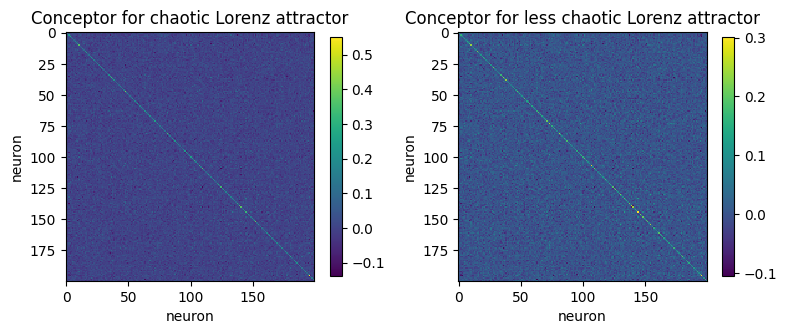

In [28]:
crnn = ConceptorRNN(rnn.W, rnn.W_in, rnn.bias)

alpha = 400.0
crnn.learn_conceptor(labels[0], y_col, alpha=alpha)
crnn.learn_conceptor(labels[1], y_col2, alpha=alpha)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for ax, key in zip(axes, labels):
    C = crnn.conceptors[key]
    im = ax.imshow(C.detach().cpu().numpy(), aspect="equal", interpolation="none", cmap="viridis")
    plt.colorbar(im, ax=ax, shrink=0.65)
    ax.set_xlabel("neuron")
    ax.set_ylabel("neuron")
    ax.set_title(f"Conceptor for {key} Lorenz attractor")
plt.tight_layout()

Conceptors can also be combined via logical operations.
For example, *NOT C* is given by $I - C$. Other logical operations such as *AND* and *OR* are also defined on conceptors. 

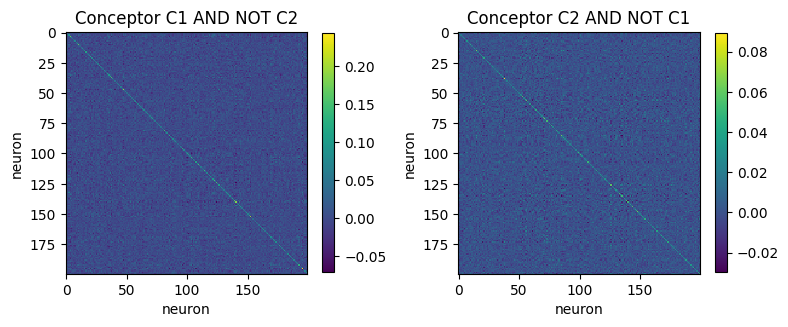

In [29]:
# get conceptors
C1, C2 = crnn.conceptors[labels[0]], crnn.conceptors[labels[1]]
C1, C2 = C1.cpu().detach().numpy(), C2.cpu().detach().numpy()

# create new conceptor that represents NOT C1/C2
C1n, C2n = AND(C1, NOT(C2)), AND(C2, NOT(C1))

# plotting
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for ax, key, C in zip(axes, ["C1 AND NOT C2", "C2 AND NOT C1"], [C1n, C2n]):
    im = ax.imshow(C, aspect="equal", interpolation="none", cmap="viridis")
    plt.colorbar(im, ax=ax, shrink=0.65)
    ax.set_xlabel("neuron")
    ax.set_ylabel("neuron")
    ax.set_title(f"Conceptor {key}")
plt.tight_layout()

Let's see what conceptors do to the network dynamics.
Below, we do the following.

1. For each conceptor, we run the conceptor-controlled network dynamics driven by the respective input pattern
2. Train a combined readout $W_{out}$
3. Train a combined input reconstruction $D$

**Comments for working through the notebook yourself:**

The aperture parameter `alpha` determines how sparse a conceptor matrix is. Try out different values of `alpha` (can be any positive real number) and see how it affects the network dynamics below.

In [30]:
conceptors = [C1, C2]

# harvesting time
y_all, inp_all, targ_all = [], [], []
for inp_tmp, targ_tmp, C in zip([inputs, inputs_new], [targets, targets_new], conceptors):
    crnn.y = y0[:]
    crnn.C = torch.tensor(C, device=device, dtype=dtype)
    for step in range(steps-lag):
        crnn.forward_c(inp_tmp[step])
        y_all.append(crnn.y)
        targ_all.append(targ_tmp[step])
        inp_all.append(inp_tmp[step])
y_all = torch.stack(y_all, dim=0)
inp_all = torch.stack(inp_all, dim=0)
targ_all = torch.stack(targ_all, dim=0)

# load all inputs into RNN weights
D_all, epsilon = crnn.load_input(y_all[:-1].T, inp_all[1:].T, tychinov, overwrite=True)
print(f"Input loading error: {float(torch.mean(epsilon).cpu().detach().numpy())}")

# train readout
W_out_all, epsilon = crnn.train_readout(y_all.T, targ_all.T, tychinov)
print(f"Readout training error: {float(torch.mean(epsilon).cpu().detach().numpy())}")

Input loading error: 0.0027525122234007098
Readout training error: 0.0018394616522931899


From our previous discussion of do's and dont's of training RNNs on multiple tasks, we expect the autonomous RNN dynamics for $W_{out}$ and $D$ to be nonsense. Let's check that.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


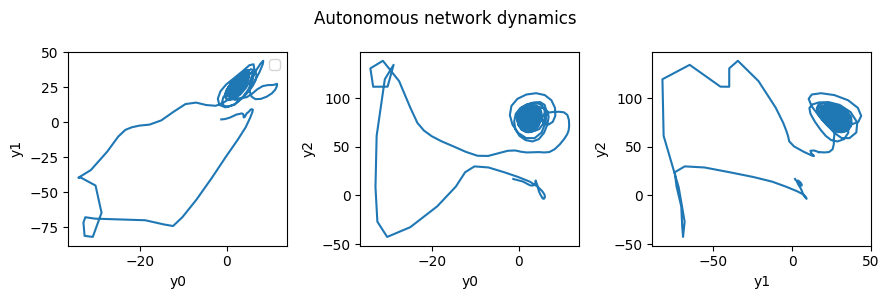

In [31]:
# autonomous network dynamics
s0 = []
for step in range(plot_steps):   
    y = W_out_all @ crnn.forward_a()
    s0.append(y.cpu().detach().numpy())
s0 = np.asarray(s0)

# plot autonomous network dynamics
fig, axes = plt.subplots(ncols=n_in, figsize=(9, 3))
for i in range(n_in):
    ax = axes[i]
    idx = combinations[i]
    ax.plot(s0[:plot_steps, idx[0]], s0[:plot_steps, idx[1]])
    ax.set_xlabel(f"y{idx[0]}")
    ax.set_ylabel(f"y{idx[1]}")
    if i == 0:
        ax.legend()
fig.suptitle("Autonomous network dynamics")
plt.tight_layout()

Now, let's see how these network dynamics are altered when we apply the conceptors C1 vs. C2 to the network update equation. 

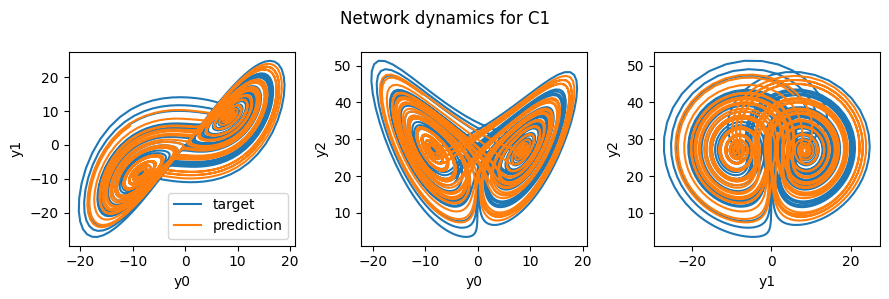

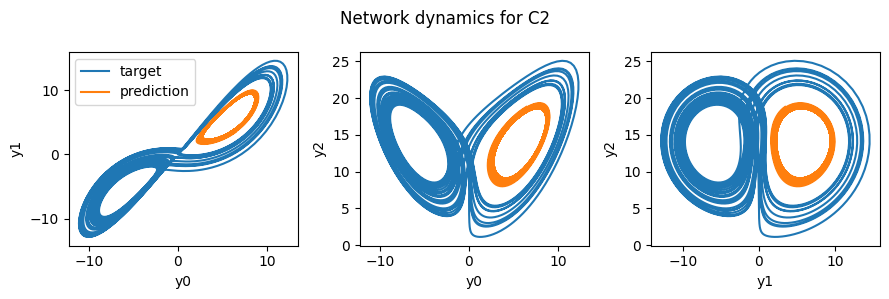

In [32]:
start = 500

# network dynamics with C1 activated
crnn.C = torch.tensor(conceptors[0], device=device, dtype=dtype)
crnn.y = y0
s1 = []
for step in range(plot_steps):   
    y = W_out_all @ crnn.forward_c_a()
    s1.append(y.cpu().detach().numpy())
s1 = np.asarray(s1)

# plot network dynamics for C1
fig, axes = plt.subplots(ncols=n_in, figsize=(9, 3))
for i in range(n_in):
    ax = axes[i]
    idx = combinations[i]
    ax.plot(targets[start:plot_steps, idx[0]], targets[start:plot_steps, idx[1]], label="target")
    ax.plot(s1[start:plot_steps, idx[0]], s1[start:plot_steps, idx[1]], label="prediction")
    ax.set_xlabel(f"y{idx[0]}")
    ax.set_ylabel(f"y{idx[1]}")
    if i == 0:
        ax.legend()
fig.suptitle("Network dynamics for C1")
plt.tight_layout()

# network dynamics for C2
crnn.C = torch.tensor(conceptors[-1], device=device, dtype=dtype)
crnn.y = y0
s2 = []
for step in range(plot_steps):   
    y = W_out_all @ crnn.forward_c_a()
    s2.append(y.cpu().detach().numpy())
s2 = np.asarray(s2)

# plot network dynamics for C2
fig2, axes2 = plt.subplots(ncols=n_in, figsize=(9, 3))
for i in range(n_in):
    ax = axes2[i]
    idx = combinations[i]
    ax.plot(targets_new[start:plot_steps, idx[0]], targets_new[start:plot_steps, idx[1]], label="target")
    ax.plot(s2[start:plot_steps, idx[0]], s2[start:plot_steps, idx[1]], label="prediction")
    ax.set_xlabel(f"y{idx[0]}")
    ax.set_ylabel(f"y{idx[1]}")
    if i == 0:
        ax.legend()
fig2.suptitle("Network dynamics for C2")
plt.tight_layout()

Why is it that conceptors force the RNN to reproduce the attractor they were driven by during training? 
It is because the minimization problem that yields conceptors is a trade-off between:

1. Not interfering with the input-driven network dynamics
2. Removing network interactions

Thus, conceptors find a sparser, most likely lower rank version of $W$ that still allows to reproduce the network dynamics that were obtained for a particular driver.
Since the readout as well as the input reconstruction for those particular network dynamics are part of $W_{out}$ and $D$, activating the conceptor for a particular driver suffices to make the network generate the target dynamics associated with that driver.

Hence, conceptors are an encoding method that allows to capture, store, and retrieve the low-dimensional manifolds of input-driven RNN dynamics. 
But conceptors can also be useful for decoding, i.e. pattern recognition tasks.
It is possible to calculate a similarity between the network state $y(n)$ and conceptors $C^k$ stored for different input patterns $x^k(n)$ via $e(n,k) = y(n) C^k y(n)'$.

This is demonstrated below.

In [33]:
# drive the network with epochs of each input and calculate the evidences for which input they are driven by
epoch_steps = 500
n_epochs = 10
input_patterns = [inputs, inputs_new]
driver, pos_evidence, neg_evidence = [], [], []
for _ in range(n_epochs):

    # randomly choose input pattern
    idx = np.random.randint(0, 2)
    inp = input_patterns[idx]
    
    for step in range(epoch_steps):

        # receive network state
        y = crnn.forward(inp[step])
        state = y.cpu().detach().numpy()

        # store true driving input identity
        d = np.zeros((2,))
        d[idx] = 1.0
        driver.append(d)

        # calculate evidence for driver identity
        e = []
        for C in [C1, C2]:
            e.append(state @ C @ state.T)
        pos_evidence.append(e/np.sum(e))
        e = []
        for C in [C1n, C2n]:
            e.append(state @ C @ state.T)
        neg_evidence.append(e/np.sum(e))

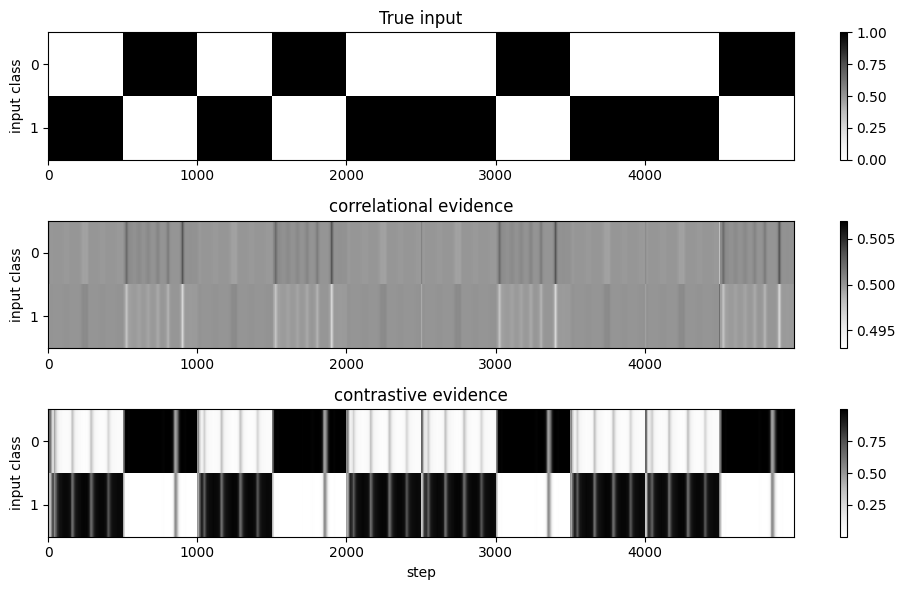

In [34]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 6))
data = [driver, pos_evidence, neg_evidence]
titles = ["True input", "correlational evidence", "contrastive evidence"]
for i in range(3):
    ax = axes[i]
    im = ax.imshow(np.asarray(data[i]).T, aspect="auto", interpolation="none", cmap="Greys")
    plt.colorbar(im)
    ax.set_yticks([0.0, 1.0])
    ax.set_ylabel("input class")
    ax.set_title(titles[i])
axes[-1].set_xlabel("step")
plt.tight_layout()